# Module 8: 時間序列特徵工程 - 2. 滑動窗口特徵 (Rolling Window Features)

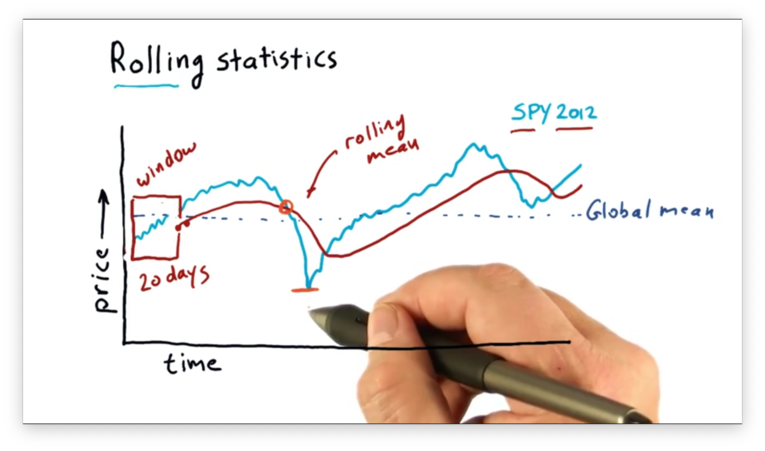

## 學習目標
- 理解滑動窗口特徵的定義、其與滯後特徵的區別，以及在時間序列分析中的重要性。
- 學習並實作如何使用 `pandas` 的 `.rolling()` 方法創建移動平均 (Moving Average)、移動標準差 (Rolling Standard Deviation) 等多種滑動統計量。
- 掌握 `window`、`min_periods` 等關鍵參數的用法及其對結果的影響。
- 透過視覺化方法觀察滑動窗口特徵如何平滑資料、捕捉局部趨勢和衡量波動性。
- 了解如何在實際應用中正確地結合滯後特徵和滑動窗口特徵，以避免數據洩漏。

## 導論：如何從時間序列中提取「近期行為」的統計概覽？

繼上一節我們學習了如何利用過去單一時間點的觀測值（滯後特徵）來預測未來後，本節將引入另一種更為豐富和強大的時間序列特徵工程技術——**滑動窗口特徵 (Rolling Window Features)**。這類特徵是透過在一個特定大小的「窗口」上計算統計量（如平均值、標準差、最大值、最小值、總和等）來創建的。這個窗口會沿著時間序列一步步地向前滑動，在每個時間點生成一個基於過去一段時間的新特徵。

您的指南中指出：「*滑動窗口特徵用於平滑雜訊、捕捉局部趨勢、衡量波動性。*」這正是其核心價值。想像一下，我們不再只關心昨天的銷售量，而是過去 7 天的**平均**銷售量，這能為模型提供一個更穩定、更具代表性的近期行為概覽，從而減少短期波動的影響，並更好地捕捉局部趨勢。

### 為什麼滑動窗口特徵至關重要？
1.  **平滑雜訊 (Smoothing)**：最常見的應用是移動平均 (Moving Average)。它可以有效地消除時間序列中的短期隨機波動，使潛在的長期趨勢或週期性模式更加清晰可見。這有助於模型專注於重要的信號而非雜訊。
2.  **捕捉局部趨勢**：窗口內的統計數據（例如，過去 30 天的移動平均）能夠反映資料在最近一段時間內的行為模式或趨勢。這使得模型能夠感知到近期資料的「動能」或「方向」。
3.  **衡量波動性 (Volatility)**：滑動標準差 (Rolling Standard Deviation) 是一個極佳的指標，可以用來衡量時間序列在特定時間窗口內的波動程度或風險水平。這對於金融市場分析或異常偵測等應用尤其重要。
4.  **豐富模型輸入**：通過提供多種統計概覽（均值、中位數、極值、離散度），滑動窗口特徵為機器學習模型提供了更為立體和全面的時間上下文信息，從而顯著提升模型的預測能力。

---

## 1. 載入套件與資料

我們將繼續使用在 `01_lag_features.py` 中引入的**電力消耗資料集**，但為了方便示例，我們將其處理為每日的平均電力消耗量。這個真實世界的數據集將幫助我們演示滑動窗口特徵的實用性，特別是在捕捉電力消耗趨勢和波動性方面。

**請注意**：此處預設資料檔案為 `household_power_consumption.txt`，請確保您已從 [Kaggle](https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set) 下載並放置在 `../../datasets/raw/power_consumption/` 路徑下。

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 設定繪圖樣式
# 'seaborn-v0_8-whitegrid' 提供了帶有白色網格的 seaborn 預設風格，更易於讀取
plt.style.use('seaborn-v0_8-whitegrid')
# 設置中文字體，以防圖表標題或標籤出現亂碼
# 請確保您的環境中已安裝 'Microsoft JhengHei' 或其他中文字型
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
print("Matplotlib and Seaborn styles configured.")

# 資料路徑
DATASET_PATH_TXT = '../../../../datasets/raw/power_consumption/household_power_consumption.txt'
# DATASET_PATH_TXT = r'..\..\..\..\datasets\raw\power_consumption\household_power_consumption.txt'

# 檢查資料是否存在，若不存在則創建一個虛擬資料集
if not os.path.exists(DATASET_PATH_TXT):
    print(f"錯誤：找不到 '{DATASET_PATH_TXT}' 檔案。")
    print(f"請確認您已將資料下載至 '{os.path.abspath(DATASET_PATH_TXT)}'")
    print("將創建一個虛擬資料集用於演示。")
    date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='D')
    dummy_data = np.random.randn(len(date_rng)).cumsum() + 35000
    df_power = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_kW'])
else:
    print(f"正在從 '{DATASET_PATH_TXT}' 載入電力消耗資料...")
    try:
        # 由於原始資料格式為分號分隔，且包含日期時間需要合併解析，還有缺失值需要處理
        df_power_raw = pd.read_csv(
            DATASET_PATH_TXT, 
            sep=';', 
            parse_dates={'Datetime': ['Date', 'Time']},
            index_col='Datetime',
            na_values=['?'],
            low_memory=False # 避免 dtype warning
        )
        print("原始電力消耗資料載入成功！")

        # 選擇 'Global_active_power' 列並重採樣到每日平均值
        if 'Global_active_power' in df_power_raw.columns:
            # 將數據重採樣到每日平均，並去除可能因重採樣導致的 NaN
            df_power_daily = df_power_raw['Global_active_power'].resample('D').mean().dropna()
            df_power_daily.rename('Consumption_kW', inplace=True)
            df_power = pd.DataFrame(df_power_daily)
            print("電力消耗資料已成功處理為每日平均值！")
            print(f"處理後資料集形狀: {df_power.shape}")
            display(df_power.head())
        else:
            print("錯誤：'Global_active_power' 欄位不存在。將創建一個虛擬資料集。")
            date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='D')
            dummy_data = np.random.randn(len(date_rng)).cumsum() + 35000
            df_power = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_kW'])
            print("虛擬資料集創建完成！")
    except Exception as e:
        print(f"載入或處理資料時發生錯誤: {e}。將創建一個虛擬資料集。")
        date_rng = pd.date_range(start='2015-01-01', end='2018-01-01', freq='D')
        dummy_data = np.random.randn(len(date_rng)).cumsum() + 35000
        df_power = pd.DataFrame(dummy_data, index=date_rng, columns=['Consumption_kW'])
        print("虛擬資料集創建完成！")

# 確保 df_power 不是空的 DataFrame 才顯示 head
if not df_power.empty:
    print("原始電力消耗資料 (前5筆):")
    display(df_power.head())



Matplotlib and Seaborn styles configured.
正在從 '../../../../datasets/raw/power_consumption/household_power_consumption.txt' 載入電力消耗資料...


C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_57568\1116291314.py:32: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df_power_raw = pd.read_csv(


原始電力消耗資料載入成功！
電力消耗資料已成功處理為每日平均值！
處理後資料集形狀: (1433, 1)


C:\Users\SUNNIE.GD.WENG\AppData\Local\Temp\ipykernel_57568\1116291314.py:32: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_power_raw = pd.read_csv(


,Consumption_kW
Datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


原始電力消耗資料 (前5筆):


,Consumption_kW
Datetime,
2006-12-16,3.053475
2006-12-17,2.354486
2006-12-18,1.530435
2006-12-19,1.157079
2006-12-20,1.545658


**結果解讀**：

我們已經成功載入並將電力消耗數據處理為每日平均值。數據集以日期為索引，包含單一的 `Consumption_kW` 欄位。這正是我們應用滑動窗口特徵的理想格式。接下來，我們將利用 `pandas` 的 `.rolling()` 方法，從這個時間序列中提取移動平均值和其他統計量。

## 2. 創建移動平均特徵 (Moving Average)

**移動平均 (Moving Average, MA)** 是最常用也最基礎的滑動窗口特徵之一。它在每個時間點計算過去 `n` 個時間點的平均值，從而平滑時間序列的短期波動，更好地揭示其潛在的趨勢。我們將創建基於過去 7 天和 30 天的移動平均消耗量，這有助於模型理解近期（週級別）和中期（月級別）的電力消耗趨勢。

### `.rolling()` 方法關鍵參數：
-   `window`: 窗口的大小，即要計算統計量的過去時間點的數量（例如，`window=7` 表示過去 7 天）。
-   `min_periods`: 窗口中要求的最小觀測數。如果設定為小於 `window` 的值，則在窗口尚未完全填滿時也會開始計算（例如，`window=7, min_periods=1` 意味著即使只有 1 天數據也會計算移動平均）。默認情況下，它等於 `window` 的大小。
-   `center`: 布林值，決定窗口的標籤是在窗口中間還是右邊。默認是 `False`，即標籤在窗口的右邊（代表當前時間點的移動平均是基於當前點及之前的數據）。

**注意**：類似於滯後特徵，`rolling()` 操作的結果在序列的開頭也會產生缺失值 (NaN)，因為在窗口完全填滿之前，沒有足夠的歷史資料來計算統計量。這些 NaN 值在模型訓練前通常需要被處理。

In [6]:
print("正在創建移動平均特徵...")
# 創建 7 天移動平均：代表過去一週的平均消耗量
df_power['consumption_ma_7'] = df_power['Consumption_kW'].rolling(window=7, min_periods=1).mean()

# 創建 30 天移動平均：代表過去一個月的平均消耗量
df_power['consumption_ma_30'] = df_power['Consumption_kW'].rolling(window=30, min_periods=1).mean()

# 由於 rolling 操作，開頭會產生 NaN 值（如果 min_periods 未設為1或有其他聚合函數）
# 在此範例中，由於 min_periods=1，只有少數特定情況才會產生 NaN，但仍需注意最終處理
# df_power_cleaned = df_power.dropna() # 最終數據集處理會移除NaN

print("移動平均特徵創建完成！")
print("加入移動平均特徵後的資料 (前5筆，包含 NaN 值)：")
display(df_power.head(30))



正在創建移動平均特徵...
移動平均特徵創建完成！
加入移動平均特徵後的資料 (前5筆，包含 NaN 值)：


,Consumption_kW,consumption_ma_7,consumption_ma_30
Datetime,,,
2006-12-16,3.053475,3.053475,3.053475
2006-12-17,2.354486,2.703980,2.703980
2006-12-18,1.530435,2.312799,2.312799
2006-12-19,1.157079,2.023869,2.023869
2006-12-20,1.545658,1.928227,1.928227
2006-12-21,1.193758,1.805815,1.805815
2006-12-22,1.625929,1.780117,1.780117
2006-12-23,3.314851,1.817457,1.971959
2006-12-24,1.770842,1.734079,1.949613


**結果解讀**：

新增的 `consumption_ma_7` 和 `consumption_ma_30` 欄位分別代表了當前日期前 7 天和 30 天的平均電力消耗。在數據的開頭部分，這些移動平均值可能因為窗口數據不足而與實際值差異較大。移動平均作為一種平滑技術，能夠減少短期波動的影響，更好地突顯長期趨勢。例如，一個穩定的上升趨勢在移動平均線上會顯得更加清晰。

### 2.1 視覺化移動平均：平滑與趨勢的展現

將移動平均線與原始序列繪製在同一張圖上，可以非常直觀地看到它們的平滑效果，以及如何捕捉不同時間尺度的趨勢。短期的移動平均線（如 7 天）會緊隨原始數據的波動，而長期的移動平均線（如 30 天）則會更加平滑，更能反映出大趨勢或季節性。

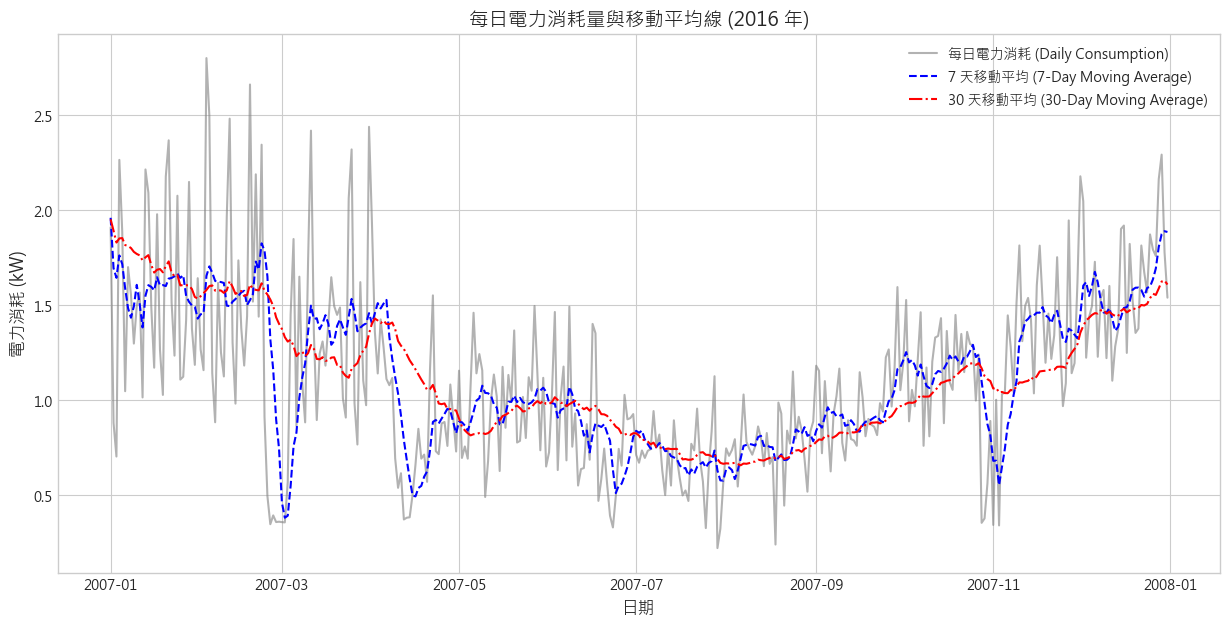

In [8]:
# 只取一部分資料進行視覺化 (例如一年)，以便圖表更清晰
df_plot = df_power['2007-01-01':'2007-12-31'] # 選擇電力消耗資料中的一年數據

plt.figure(figsize=(15, 7))
plt.plot(df_plot.index, df_plot['Consumption_kW'], label='每日電力消耗 (Daily Consumption)', alpha=0.6, color='gray')
plt.plot(df_plot.index, df_plot['consumption_ma_7'], label='7 天移動平均 (7-Day Moving Average)', linestyle='--', color='blue')
plt.plot(df_plot.index, df_plot['consumption_ma_30'], label='30 天移動平均 (30-Day Moving Average)', linestyle='-.', color='red')

plt.title('每日電力消耗量與移動平均線 (2016 年)', fontsize=14)
plt.xlabel('日期', fontsize=12)
plt.ylabel('電力消耗 (kW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()



**討論**：

從圖中可以看出，7 日移動平均線能夠較快地響應原始數據的短期變化，而 30 日移動平均線則更加平滑，能夠更好地突顯季節性的長期趨勢。例如，夏季和冬季的用電高峰在 30 日移動平均線上會顯得更為顯著。這種平滑效果使得模型在預測時能夠更好地關注數據的整體模式，而非單日的隨機波動。

## 3. 創建其他滑動窗口統計量：量化波動性與極值

除了移動平均，我們還可以計算其他多樣化的滑動窗口統計量，以捕捉時間序列的不同特性。例如，滑動標準差可以衡量資料的波動性，而滑動最大值和最小值則能捕捉資料在某段時間內的極端行為。

In [10]:
print("正在創建其他滑動窗口特徵 (標準差、最大值、最小值)...")
# 創建 7 天的滑動標準差 (衡量近期波動性)
df_power['consumption_std_7'] = df_power['Consumption_kW'].rolling(window=7, min_periods=1).std()

# 創建 7 天的滑動最大值 (衡量近期高點)
df_power['consumption_max_7'] = df_power['Consumption_kW'].rolling(window=7, min_periods=1).max()

# 創建 7 天的滑動最小值 (衡量近期低點)
df_power['consumption_min_7'] = df_power['Consumption_kW'].rolling(window=7, min_periods=1).min()

# 此處不立即dropna，在最後統一處理

print("更多滑動窗口特徵創建完成！")
print("加入更多滑動窗口特徵後的資料 (前5筆)：")
display(df_power.head())



正在創建其他滑動窗口特徵 (標準差、最大值、最小值)...
更多滑動窗口特徵創建完成！
加入更多滑動窗口特徵後的資料 (前5筆)：


,Consumption_kW,consumption_ma_7,consumption_ma_30,consumption_std_7,consumption_max_7,consumption_min_7
Datetime,,,,,,
2006-12-16,3.053475,3.053475,3.053475,NaN,3.053475,3.053475
2006-12-17,2.354486,2.703980,2.703980,0.494260,3.053475,2.354486
2006-12-18,1.530435,2.312799,2.312799,0.762375,3.053475,1.530435
2006-12-19,1.157079,2.023869,2.023869,0.849352,3.053475,1.157079
2006-12-20,1.545658,1.928227,1.928227,0.766020,3.053475,1.157079


**結果解讀**：

新增的 `consumption_std_7`、`consumption_max_7` 和 `consumption_min_7` 特徵為模型提供了關於近期數據波動範圍和極值的洞察。例如，`consumption_std_7` 可以在電力消耗變化劇烈時提供高值，這對於識別異常事件或理解系統壓力非常有用。這些特徵對於捕捉時間序列的動態行為至關重要。

### 3.1 視覺化滑動標準差：波動性的時間演變

將滑動標準差獨立繪製出來，可以清晰地看到資料波動性隨時間的變化。這對於監控系統穩定性、風險評估或識別市場動態非常有用。

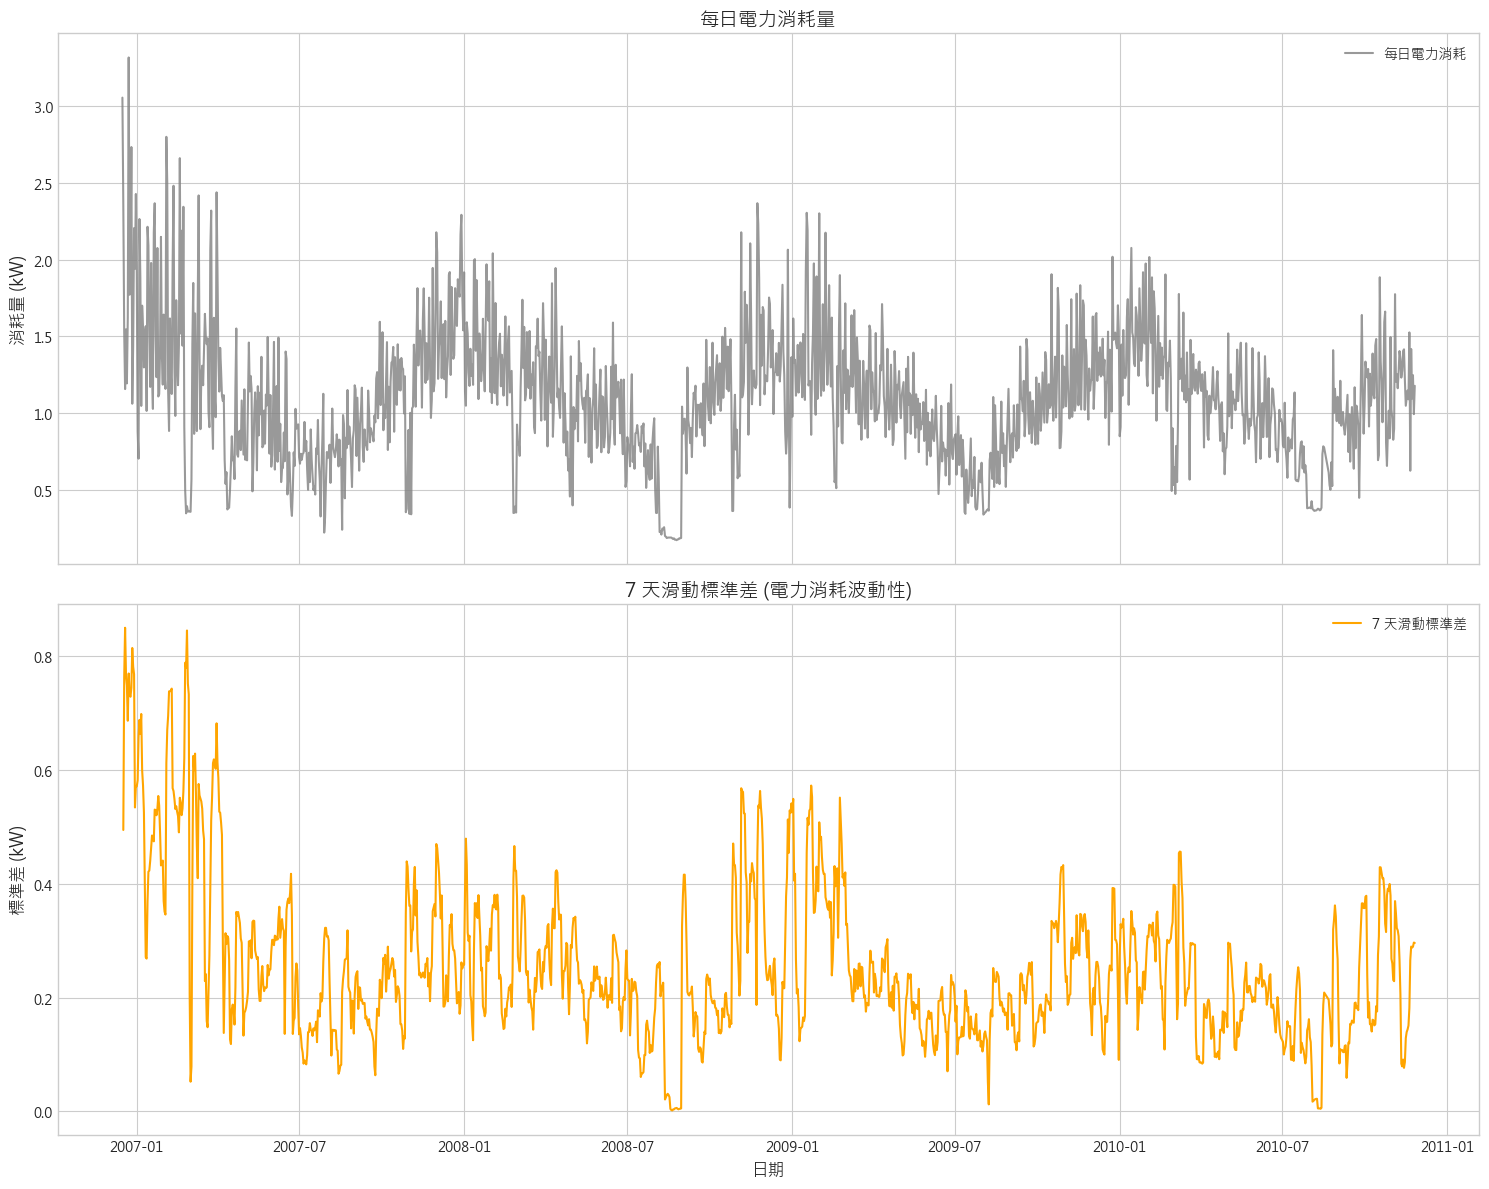

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True) # sharex=True 讓兩個子圖的 x 軸同步

# 繪製原始消耗量
ax1.plot(df_power.index, df_power['Consumption_kW'], label='每日電力消耗', color='gray', alpha=0.8)
ax1.set_title('每日電力消耗量', fontsize=14)
ax1.set_ylabel('消耗量 (kW)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True)

# 繪製 7 日滑動標準差
ax2.plot(df_power.index, df_power['consumption_std_7'], label='7 天滑動標準差', color='orange', linestyle='-')
ax2.set_title('7 天滑動標準差 (電力消耗波動性)', fontsize=14)
ax2.set_ylabel('標準差 (kW)', fontsize=12)
ax2.set_xlabel('日期', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True)

plt.tight_layout() # 自動調整佈局
plt.show()



**討論**：

從下方的滑動標準差圖可以看出，電力消耗在某些時期會呈現較高的波動性。例如，在夏季（空調需求高）和冬季（供暖需求高）的極端天氣期間，電力消耗的變化可能更為劇烈，導致標準差升高。這種波動性特徵對於預測模型來說是重要的輸入，它可以幫助模型了解不確定性，或者在異常事件發生時提供預警。

## 4. 結合滯後特徵與滑動窗口特徵：構建更全面的時間上下文

在實際的時間序列預測任務中，我們通常會將滯後特徵和滑動窗口特徵結合起來使用，以構建一個更為全面和豐富的時間上下文。一個常見且高效的實踐是：**先計算滑動窗口統計量，然後再對其進行滯後操作**。這樣可以避免數據洩漏，同時確保新的特徵只包含預測點之前的資訊。

例如，我們可能對 `t-1` 時刻的「過去 7 天的平均銷售量」感興趣。這可以通過先計算 7 天移動平均，然後再對這個移動平均序列進行 `shift(1)` 操作來實現。這種組合特徵在預測時，能夠提供基於前一時間步的近期歷史趨勢和波動性，對於捕捉動態的市場或環境變化非常有效。

In [15]:
print("正在結合滯後特徵與滑動窗口特徵...")
# 重新從原始每日數據開始，確保清晰的步驟
df_final = df_power[['Consumption_kW']].copy()

# 創建滯後 1 期特徵：昨天消耗量
df_final['consumption_lag_1'] = df_final['Consumption_kW'].shift(1)

# 創建滯後 1 期的 7 天移動平均：代表昨天結束時，過去 7 天的平均消耗量
# 先計算 7 天移動平均
ma_7 = df_final['Consumption_kW'].rolling(window=7, min_periods=1).mean()
# 再對移動平均結果進行滯後 1 期操作
df_final['consumption_ma_7_lag_1'] = ma_7.shift(1)

# 創建滯後 1 期的 7 天滑動標準差：代表昨天結束時，過去 7 天的消耗量波動性
# 先計算 7 天滑動標準差
std_7 = df_final['Consumption_kW'].rolling(window=7, min_periods=1).std()
# 再對標準差結果進行滯後 1 期操作
df_final['consumption_std_7_lag_1'] = std_7.shift(1)

# 移除因滯後或滾動操作產生的所有 NaN 值
df_final.dropna(inplace=True)

print("結合滯後與滑動特徵的資料創建完成！")
print("結合滯後與滑動特徵後的最終資料 (前5筆)：")
display(df_final.head())

print(f"\n最終資料集形狀: {df_final.shape}")



正在結合滯後特徵與滑動窗口特徵...
結合滯後與滑動特徵的資料創建完成！
結合滯後與滑動特徵後的最終資料 (前5筆)：


,Consumption_kW,consumption_lag_1,consumption_ma_7_lag_1,consumption_std_7_lag_1
Datetime,,,,
2006-12-18,1.530435,2.354486,2.703980,0.494260
2006-12-19,1.157079,1.530435,2.312799,0.762375
2006-12-20,1.545658,1.157079,2.023869,0.849352
2006-12-21,1.193758,1.545658,1.928227,0.766020
2006-12-22,1.625929,1.193758,1.805815,0.747888



最終資料集形狀: (1431, 4)


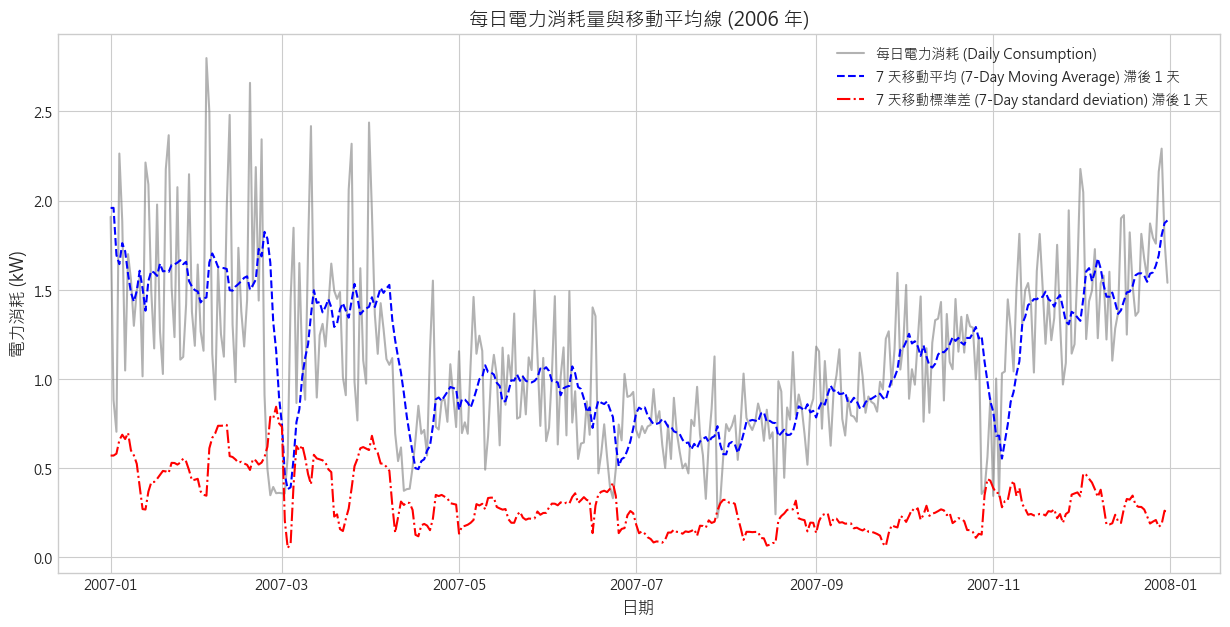

In [18]:
# 只取一部分資料進行視覺化 (例如一年)，以便圖表更清晰
df_plot = df_final['2007-01-01':'2007-12-31'] # 選擇電力消耗資料中的一年數據

plt.figure(figsize=(15, 7))
plt.plot(df_plot.index, df_plot['Consumption_kW'], label='每日電力消耗 (Daily Consumption)', alpha=0.6, color='gray')
plt.plot(df_plot.index, df_plot['consumption_ma_7_lag_1'], label='7 天移動平均 (7-Day Moving Average) 滯後 1 天', linestyle='--', color='blue')
plt.plot(df_plot.index, df_plot['consumption_std_7_lag_1'], label='7 天移動標準差 (7-Day standard deviation) 滯後 1 天', linestyle='-.', color='red')

plt.title('每日電力消耗量與移動平均線 (2006 年)', fontsize=14)
plt.xlabel('日期', fontsize=12)
plt.ylabel('電力消耗 (kW)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()



**解釋與討論**：

`consumption_ma_7_lag_1` 這個特徵代表了在**昨天**的那個時間點上，過去 7 天的平均消耗量。它提供了一個平滑的、前瞻性的趨勢信息，不包含任何關於「今天」的數據，因此完全避免了數據洩漏。同樣，`consumption_std_7_lag_1` 則提供了「昨天」結束時，過去 7 天的電力消耗波動性。這種組合特徵在預測時，能夠提供基於前一時間步的近期歷史趨勢和波動性，對於捕捉動態的市場或環境變化非常有效。

## 5. 總結：時間序列特徵工程的強大基石

滑動窗口特徵是時間序列特徵工程中一個極其強大和靈活的工具，與滯後特徵相輔相成，共同構成了時間序列預測的基石。它們使我們能夠從歷史數據中提取豐富的統計概覽，從而平滑雜訊、捕捉局部趨勢、衡量波動性，並最終顯著提升機器學習模型在時間序列預測任務中的性能。

本節我們學習了以下核心知識點：

| 概念/方法 | 核心作用 | 實作工具/考量點 |
|:---|:---|:---|
| **滑動窗口特徵** | 在固定窗口內計算統計量，捕捉近期趨勢、波動性 | `pandas.Series.rolling()`
| **移動平均 (MA)** | 平滑短期波動，揭示趨勢 | `rolling(...).mean()` | 
| **滑動標準差 (Std)** | 衡量資料在近期內的波動性 | `rolling(...).std()` |
| **結合滯後與滾動** | 構建更豐富的時間上下文，避免數據洩漏 | **先 `rolling()`，再 `shift()`** |

在實際應用中，選擇合適的窗口大小和統計量非常關鍵，這通常需要結合領域知識和對數據的探索性分析。在接下來的筆記本中，我們將會進一步探索更多時間序列的特徵工程方法，例如如何處理日期和時間特徵，以及如何進行季節性與趨勢分解，以應對更複雜的時間序列模式.